# Classification을 위해 feature가 학습될 때 localization에도 도움이 된다는 걸 알 수 있다.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#데이터셋 준비(classification처럼)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/images.tar.gz

In [4]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/annotations.tar.gz

In [5]:
!ls

annotations  gdrive  images  sample_data


In [6]:
cur_dir = os.getcwd()
image_dir = os.path.join(cur_dir,'images')
bbox_dir = os.path.join(cur_dir,'annotations','xmls')
seg_dir = os.path.join(cur_dir,'annotations','trimaps')
#경로는 content 바로 아래 풀려있다

In [7]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']#확장자가 jpg인거만
print(len(image_files))#7390개

7390


In [8]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']#확장자가 xml인거만
print(len(bbox_files))#3686개 (모든 이미지에 대해 bound box가 있는건 아님)
#bbox에서 읽어와서 .xml떼고 .jpg붙이고 tfrecord에 저장

3686


In [9]:
#image file중 channel이 3이 아니면 삭제하고 xml에서 읽어오니까 bbox_files에서도 삭제
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    bbox_file = os.path.splitext(image_file)[0]+'.xml'
    bbox_path = os.path.join(bbox_dir, bbox_file)
    image = Image.open(image_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(image_file, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(image_path)
        try:
            os.remove(bbox_path)
        except FileNotFoundError:
            pass
#channel 4개 혹은 흑백이미지 삭제

Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_167.jpg P
(275, 183)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_145.jpg P
(188, 216)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_139.jpg P
(250, 350)


In [10]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))#7378개
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']#
print(len(bbox_files))#3685개
#걸러지고 남은 파일 갯수 확인

7378
3685


In [11]:
#집합으로 이름을 정리
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+','',file_name)#뒤에 숫자 pug_111같은거에서 삭제
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [12]:
#정렬
class_list.sort()
#딕셔너리로 만들어서 one-hot encoding쉽게하자
class2idx = {cls:idx for idx,cls in enumerate(class_list)}

In [13]:
#하이퍼 파라미터
IMG_SIZE = 224
N_BBOX = len(bbox_files)#3685
N_TRAIN = 3000
N_VAL = N_BBOX - N_TRAIN#685개로

In [14]:
#tfreord저장할곳
#tfrecord file이란 tf를 위한 바이너리 파일 파이프라인 자동 구성됨.
tfr_dir = os.path.join(cur_dir,'tfrecord')
os.makedirs(tfr_dir,exist_ok=True)

tfr_train_dir=os.path.join(tfr_dir,'cls_train.tfr')
tfr_val_dir=os.path.join(tfr_dir,'cls_val.tfr')

In [15]:
#tfrecord writer생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [16]:
#tensorflow 듀토리얼에서 긁어옴.
# https://www.tensorflow.org/tutorials/load_data/tfrecord
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [17]:
shuffle_list = list(range(N_BBOX))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

##목표!!!
###센터의 x,y좌표예측과 height와 width

In [18]:
for idx in train_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)

    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('.size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    #scaling을 통해 정규화 시키는게 낫다.학습할때
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height

    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
    #class에 대한 정보도 같이 저장
    #맨앞에 대소문자로 구분가능
    if file_name[0].islower(): #개
        bi_cls_num = 0
    else: #고양이
        bi_cls_num = 1
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num),
        'bi_cls_num': _int64_feature(bi_cls_num),
        'x': _float_feature(x),
        'y': _float_feature(y),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))
    writer_train.write(example.SerializeToString())

writer_train.close()

In [19]:
#validation 용
for idx in val_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)

    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('.size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height

    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()

    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]

    if file_name[0].islower():
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'cls_num': _int64_feature(class_num),
        'bi_cls_num': _int64_feature(bi_cls_num),
        'x': _float_feature(x),
        'y': _float_feature(y),
        'w': _float_feature(w),
        'h': _float_feature(h)
    }))
    writer_val.write(example.SerializeToString())

writer_val.close()

In [20]:
#하이퍼파라미터!!
N_CLASS = len(class_list)
N_EPOCHS = 40
N_BATCH = 40
learning_rate = 0.0001
steps_per_epoch = N_TRAIN/N_BATCH
validation_steps = int(np.ceil(N_VAL/N_BATCH))

In [21]:
# tfrecord file을 파싱
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.float32)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([bi_cls_label,x, y, w, h], -1)
    
    return image, gt #뭉쳐서 내보낸다!!

In [22]:
# train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [23]:
# validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

#모델 정의!

In [24]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [25]:
# functional api로 만들자
# 가지를 칠 때 sequential로는 못 만드니까
def MyModel():
    mobilenetv2 = MobileNetV2(weights = 'imagenet',include_top=False, input_shape = (IMG_SIZE,IMG_SIZE,3))
    gap = GlobalAveragePooling2D()(mobilenetv2.output)

    dense_b1_1 = Dense(256)(gap)
    bn_b1_2 = BatchNormalization()(dense_b1_1)
    relu_b1_3 = ReLU()(bn_b1_2)

    dense_b1_4 = Dense(64)(relu_b1_3)
    bn_b1_5 = BatchNormalization()(dense_b1_4)
    relu_b1_6 = ReLU()(bn_b1_5)

    output1 = Dense(2,activation='softmax')(relu_b1_6)

    dense_b2_1 = Dense(256)(gap)
    bn_b2_2 = BatchNormalization()(dense_b2_1)
    relu_b2_3 = ReLU()(bn_b2_2)

    dense_b2_4 = Dense(64)(relu_b2_3)
    bn_b2_5 = BatchNormalization()(dense_b2_4)
    relu_b2_6 = ReLU()(bn_b2_5)

    output2 = Dense(4,activation='sigmoid')(relu_b2_6)

    concat = Concatenate()([output1, output2])

    return keras.Model(inputs = mobilenetv2.input, outputs = concat)

In [26]:
model = MyModel()
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________________

In [27]:
# classification은 cross entropy
# locatization은 MSE
def loss_fn(y_true,y_pred):
    #gt = [bi_cls, x, y, w, h]
    cls_labels = tf.cast(y_true[:,:1],tf.int64)#float32로 return했으니까
    loc_labels = y_true[:,1:]
    #pred = [dog,cat, x,y,w,h]#concat했으니까
    cls_preds = y_pred[:,:2]#sparse로 바꾸면되니까
    loc_preds = y_pred[:,2:]
    cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(cls_labels,cls_preds)
    loc_loss = tf.keras.losses.MeanSquaredError()(loc_labels, loc_preds)
    # 1:5의 비율로
    # localization에 집중을 했으면 좋겠음.
    return cls_loss + 5*loc_loss

In [28]:

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

model.compile(keras.optimizers.RMSprop(lr_schedule, momentum = 0.9), loss=loss_fn)

###학습시작

In [29]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/40
75/75 [==============================] - 34s 454ms/step - loss: 0.2823 - val_loss: 8.2566
Epoch 2/40
75/75 [==============================] - 33s 440ms/step - loss: 0.1197 - val_loss: 10.7333
Epoch 3/40
75/75 [==============================] - 33s 441ms/step - loss: 0.0934 - val_loss: 10.4588
Epoch 4/40
75/75 [==============================] - 33s 442ms/step - loss: 0.0850 - val_loss: 7.9998
Epoch 5/40
75/75 [==============================] - 33s 443ms/step - loss: 0.0665 - val_loss: 2.1976
Epoch 6/40
75/75 [==============================] - 33s 443ms/step - loss: 0.0458 - val_loss: 2.4525
Epoch 7/40
75/75 [==============================] - 33s 443ms/step - loss: 0.0561 - val_loss: 3.7418
Epoch 8/40
75/75 [==============================] - 33s 442ms/step - loss: 0.0459 - val_loss: 4.9404
Epoch 9/40
75/75 [==============================] - 33s 443ms/step - loss: 0.0407 - val_loss: 0.7880
Epoch 10/40
75/75 [==============================] - 33s 441ms/step - loss: 0.0394 - val_

## 예측한 bounding box와 ground truth box를 image에 같이 표시
### 정답은 빨간색 box, 예측은 파란색 box

In [54]:
idx = 0
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):
    # 정답 부분
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 부분
    ## validation set에 대해서 박스 추측
    prediction = model.predict(val_data)
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[idx])
    plt.show()

# classification을 같이해서 multi task loss를 주니까 훨씬 잘 되는것처럼 보임

Output hidden; open in https://colab.research.google.com to view.

##iou계산(면적이 얼마나 맞았냐 면적로 계산!!)


In [56]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH #5
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    #각 배치당
    flag = (i == validation_steps-1)
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    prediction = model.predict(val_data)
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    for idx in range(N_BATCH):
        #배치는 40개니까 맨뒤에 남는 자투리 계산 685개의 val data니까
        if(flag):
            if idx == res:
                flag = False
                break          
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

        #겹치는 영역넘어버리면 애초에 할 필요가 없제!!
        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        #두개 박스를 포함하는 가장 최소의 직사각형
        w_union = np.max((xmax, pred_xmax)) - np.min((xmin, pred_xmin))
        h_union = np.max((ymax, pred_ymax)) - np.min((ymin, pred_ymin))
        #두개의 박스가 교차하는 박스
        w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

        #union - inter = 짜투리사각형
        w_sub1 = np.abs(xmax - pred_xmax)
        h_sub1 = np.abs(ymax - pred_ymax)
        w_sub2 = np.abs(xmin - pred_xmin)
        h_sub2 = np.abs(ymin - pred_ymin)

        iou = (w_inter * h_inter) / ((w_union * h_union) - (w_sub1 * h_sub1) - (w_sub2 * h_sub2))
        avg_iou += iou / N_VAL

print(avg_iou)
## 0.49(vanila) -> 0.67(mobilenet) -> 0.72(mobilenet + classfication)

0.7211310845318366


# image test

In [40]:
#dog
image = Image.open('doggydog.jpeg')
image = image.resize((224,224))
image = np.array(image)
image = image/255.

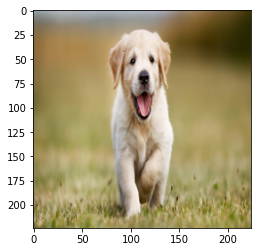

In [41]:
plt.imshow(image)
plt.show()

In [42]:
image = np.reshape(image,(1,224,224,3))

In [43]:
pred = model.predict(image)
pred

array([[9.9999940e-01, 5.8906966e-07, 4.9111035e-01, 2.7933788e-01,
        2.3808287e-01, 3.5402367e-01]], dtype=float32)

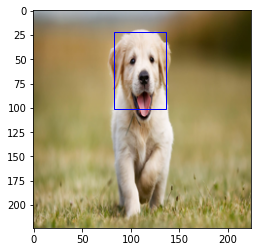

In [46]:

pred_x = pred[0,2]
pred_y = pred[0,3]
pred_w = pred[0,4]
pred_h = pred[0,5]
pred_xmin = pred_x - pred_w/2
pred_ymin = pred_y - pred_h/2
pred_rect_x = int(pred_xmin * 224)
pred_rect_y = int(pred_ymin * 224)
pred_rect_w = int(pred_w * 224)
pred_rect_h = int(pred_h * 224)

pred_rect = Rectangle((pred_rect_x,pred_rect_y),pred_rect_w,pred_rect_h,
                     fill = False, color = 'blue')
plt.axes().add_patch(pred_rect)

plt.imshow(image[0])
plt.show()

In [48]:
#dog
image = Image.open('catcat.jpg')
image = image.resize((224,224))
image = np.array(image)
image = image/255.

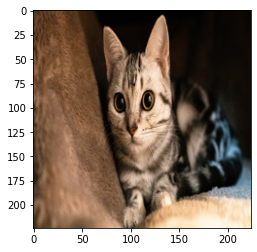

In [49]:
plt.imshow(image)
plt.show()

In [50]:
image = np.reshape(image,(1,224,224,3))

In [51]:
pred = model.predict(image)
pred

array([[1.3446671e-11, 1.0000000e+00, 4.5124477e-01, 3.5184988e-01,
        2.9786691e-01, 6.2205017e-01]], dtype=float32)

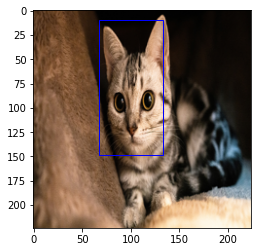

In [58]:
pred_x = pred[0,2]
pred_y = pred[0,3]
pred_w = pred[0,4]
pred_h = pred[0,5]
pred_xmin = pred_x - pred_w/2
pred_ymin = pred_y - pred_h/2
pred_rect_x = int(pred_xmin * 224)
pred_rect_y = int(pred_ymin * 224)
pred_rect_w = int(pred_w * 224)
pred_rect_h = int(pred_h * 224)

pred_rect = Rectangle((pred_rect_x,pred_rect_y),pred_rect_w,pred_rect_h,
                     fill = False, color = 'blue')
plt.axes().add_patch(pred_rect)

plt.imshow(image[0])
plt.show()

#내 얼굴로 test해보자 ㅋㅋㅋ

In [65]:
#나
image = Image.open('joonkee.jpg')
image = image.resize((224,224))
image = np.array(image)
image = image/255.

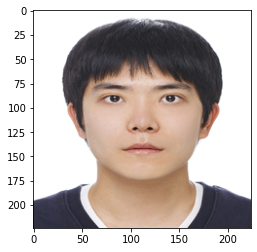

In [66]:
plt.imshow(image)
plt.show()

In [67]:
image = np.reshape(image,(1,224,224,3))

In [68]:
pred = model.predict(image)
pred

array([[6.8612461e-04, 9.9931383e-01, 5.3791302e-01, 4.8317888e-01,
        6.5509140e-01, 5.2037990e-01]], dtype=float32)

## 오 된다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

### 99% 고양이상 ㅋㅋㅋㅋㅋ

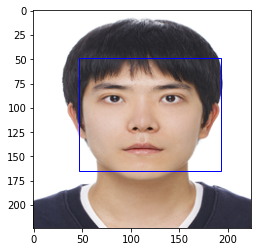

In [69]:
pred_x = pred[0,2]
pred_y = pred[0,3]
pred_w = pred[0,4]
pred_h = pred[0,5]
pred_xmin = pred_x - pred_w/2
pred_ymin = pred_y - pred_h/2
pred_rect_x = int(pred_xmin * 224)
pred_rect_y = int(pred_ymin * 224)
pred_rect_w = int(pred_w * 224)
pred_rect_h = int(pred_h * 224)

pred_rect = Rectangle((pred_rect_x,pred_rect_y),pred_rect_w,pred_rect_h,
                     fill = False, color = 'blue')
plt.axes().add_patch(pred_rect)

plt.imshow(image[0])
plt.show()